# Understanding School Performance on Pennsylvania Standardized Tests

## Extended Modeling - Part 2

The purpose of this notebook is to select one observation (i.e. one school) from our dataset and produce counterfactual explanations using our model to improve its performance standardized tests.  For simplicity, we will only look at the results for school performance on ELA standardized tests (and not math).


The school that we will select has 0 for ELA target values, meaning that 0% of students are proficient or above in ELA.  Our objective will be to see if we can find adjustments in features that will bring our target value to at least 10 (meaning 10% of students are proficient or above in ELA).  We are determining what it will take to bring our target value to this threshold.

In our previous notebook, we used the SHAP package to analyze the impact of our features on our target variable. The SHAP summary beeswarm plots are shown below:

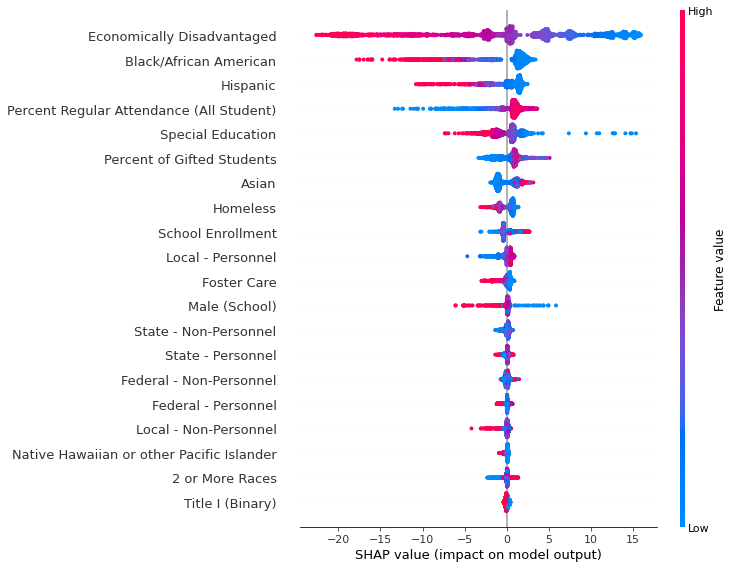

Based on our observations from the summary plot, as well as our intuition of the domain space, we will produce counterfactuals by altering the following features one at a time:
- Economically Disadvantaged
- Percent Regular Attendance (All Student)

We will also try to produce counterfactuals by altering 'Local - Personnel', which represents expenditures per student on Personnel from local sources.  In our exploratory data analysis in Tableau, we discovered that 'Local - Personnel' had a slight positive correlation with school performance in ELA, although the correlation strength was not very strong ($r^2$ = 0.05).  Based on our SHAP analysis in the previous notebook, this variable does not have a major impact on our model's predictions, but it has the most impact compared to the rest of our expenditure variables. 

When evaluating our predictions with our ELA model, we remind ourselves that the <b>mean absolute error</b> on the test set for this model is 6.68.

### Contents:

- [1 - Import packages and load files](#section1)
- [2 - Identify observation](#section2)
- [3 - Counterfactuals](#section3)
  - [3.1 - Economically disadvantaged](#section3.1)
  - [3.2 - Percent Regular Attendance (All Student)](#section3.2)
  - [3.3 - Local - Personnel](#section3.3)
- [4 - Future work](#section4)

<a id='section1'></a>
## 1. Import packages and load files

In [1]:
# import packages
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import pickle

In [2]:
# load datasets
X_train = pd.read_csv('../Data/X_train_scaled2.csv', index_col = 0)
X_test = pd.read_csv('../Data/X_test_scaled2.csv', index_col = 0)

X_train_orig = pd.read_csv('../Data/X_train.csv', index_col = 0).reset_index(drop=True)
X_test_orig = pd.read_csv('../Data/X_test.csv', index_col = 0)

ELA_train = pd.read_csv('../Data/y_train_ELA.csv', index_col = 0)
ELA_test = pd.read_csv('../Data/y_test_ELA.csv', index_col = 0)

math_train = pd.read_csv('../Data/y_train_math.csv', index_col = 0)
math_test = pd.read_csv('../Data/y_test_math.csv', index_col = 0)

In [3]:
# load highly correlated features list

with open('../Data/corr_features.pkl', 'rb') as f:
    corr_features = pickle.load(f)

In [4]:
# drop high correlation features from our original data
X_train_orig = X_train_orig.drop(corr_features, axis = 1)
X_test_orig = X_test_orig.drop(corr_features, axis = 1)

In [5]:
# load model
with open('../Models/ELA_model.pkl', 'rb') as f:
    ELA_model = pickle.load(f)

<a id='section2'></a>
## 2. Identify observation

We'll search our train and test target variables to see how many rows we have where the target variable is equal to 0. 

In [6]:
#count total number of rows with target variable = 0
sum(ELA_train['Percent Proficient in ELA']==0)

2

In [7]:
#count total number of rows with target variable = 0
sum(ELA_test['Percent Proficient in ELA']==0)

0

Our train set seems to have 2 instances with target variable equal to 0.

In [8]:
#find rows where the target variable = 0
ELA_train[ELA_train['Percent Proficient in ELA']==0]

,Percent Proficient in ELA
94,0.0
1901,0.0


We'll select the row that is indexed at 94 for our analysis.

In [9]:
index = 94

In [10]:
# observation row from train set (scaled)
X_train.iloc[index]

Title I (Binary)                             0.854268
School Enrollment                           -1.105340
Male (School)                                3.353083
Percent Regular Attendance (All Student)    -6.273694
American Indian/Alaskan Native              -0.589087
Asian                                       -0.580679
Black/African American                       3.269251
Hispanic                                    -0.464803
Native Hawaiian or other Pacific Islander   -0.435799
2 or More Races                             -0.931511
Special Education                            0.776074
Percent of Gifted Students                  -0.891939
Economically Disadvantaged                   0.825337
Foster Care                                  5.401053
Homeless                                    -0.851883
Military Connected                          -0.214851
Local - Non-Personnel                        0.503525
Local - Personnel                            4.520234
State - Non-Personnel       

In [11]:
# observation row from the original train set (unscaled)
X_train_orig.iloc[index]

Title I (Binary)                                 1.00
School Enrollment                              115.00
Male (School)                                   63.48
Percent Regular Attendance (All Student)        12.60
American Indian/Alaskan Native                   0.00
Asian                                            0.00
Black/African American                          96.52
Hispanic                                         2.61
Native Hawaiian or other Pacific Islander        0.00
2 or More Races                                  0.87
Special Education                               21.74
Percent of Gifted Students                       0.00
Economically Disadvantaged                      66.09
Foster Care                                      6.96
Homeless                                         0.00
Military Connected                               0.00
Local - Non-Personnel                         2712.94
Local - Personnel                            25885.22
State - Non-Personnel       

In [12]:
# original prediction
ELA_model.predict(X_train.iloc[index].to_numpy().transpose().reshape(1, -1))

array([5.1972203], dtype=float32)

We'll create the same standard scaler object we used when we originally preprocessed our data.

In [13]:
# instantiate standard scaler
sc = StandardScaler()

# fit the scaler on the training set and transform it
X_train_sc = sc.fit_transform(X_train_orig)

<a id='section3'></a>
## 3. Counterfactuals

<a id='section3.1'></a>
### 3.1 Economically Disadvantaged

We'll start producing counterfactuals by altering the 'Economically Disadvantaged' variable.  First, we'll look at the original value of this variable in our observation and then create a list of alternative values to replace it with and run it through our model.

In [14]:
X_train_orig.iloc[index]['Economically Disadvantaged']

66.09

Our original value for 'Economically Disadvantaged' is 66.09.  Since we know from our SHAP analysis that lower values of this variable have a positive impact on our target variable, we'll generate a list of values that incrementally decrease from the actual value.  We'll then use that list to create a dataframe with all identical features except for 'Economically Disadvantaged'

In [15]:
# create list of alternative values for 'Economically Disadvantaged'
econ = np.arange(65, 49, -1)

In [16]:
#establish observation as a dataframe
econ_df = pd.DataFrame(X_train_orig.iloc[index]).transpose().reset_index(drop = True)
econ_new_row = pd.DataFrame(X_train_orig.iloc[index]).transpose().reset_index(drop = True)

In [17]:
# iterate through list of alternatives, update variable, and append this new row
for val in econ:
    econ_new_row['Economically Disadvantaged'] = val
    econ_df = econ_df.append(econ_new_row, ignore_index=True)

In [18]:
econ_df

,Title I (Binary),School Enrollment,Male (School),Percent Regular Attendance (All Student),American Indian/Alaskan Native,Asian,Black/African American,Hispanic,Native Hawaiian or other Pacific Islander,2 or More Races,...,Economically Disadvantaged,Foster Care,Homeless,Military Connected,Local - Non-Personnel,Local - Personnel,State - Non-Personnel,State - Personnel,Federal - Non-Personnel,Federal - Personnel
0,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
1,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,65.00,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
2,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,64.00,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
3,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,63.00,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
4,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,62.00,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
5,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,61.00,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
6,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,60.00,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
7,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,59.00,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
8,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,58.00,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
9,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,57.00,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7


In [19]:
# scale the data
econ_df_sc = sc.transform(econ_df)

In [20]:
# make prediction
econ_pred = ELA_model.predict(econ_df_sc)

In [21]:
# generate a table comparing the altered value and the predicted target variable
econ_results = pd.DataFrame(zip(econ_df['Economically Disadvantaged'], list(econ_pred)), 
                            columns = ['% Economically Disadvantaged', '% Proficient in ELA (pred)']
                           )

econ_results

,% Economically Disadvantaged,% Proficient in ELA (pred)
0,66.09,5.197220
1,65.00,10.263416
2,64.00,10.263416
3,63.00,12.727907
4,62.00,12.539217
5,61.00,12.539217
6,60.00,17.366093
7,59.00,17.366093
8,58.00,18.949980
9,57.00,16.464533


Our results show us that reductions in the percentage of families that are economically disadvantaged in a school is correlated with improved school performance in ELA.  Just reducing the percentage from 66.09 to 65 already brings the predicted percent proficient in ELA up to 10.26%.  

If the community is able to further reduce the percentage of families that are economically disadvantaged in a school to 60%, the predicted school performance in ELA jumps up to 17.37%.  Given our model's mean absolute error of 6.68, we can expect the interval of error for this prediction to be in between 10.69% and 24.05% on average.  This would safely bring us above our threshold of achieving 10% school performance in ELA.

While we are hesitant to suggest direct causation, an argument can be made towards increasing community engagement and support services for areas with high poverty rates as a means of improving local school performance.

<a id='section3.2'></a>
### 3.2  Percent Regular Attendance

Next we'll produce counterfactuals by altering the 'Percent Regular Attendance (All Student)' variable.  First, we'll look at the original value of this variable in our observation and then create a list of alternative values to replace it with and run it through our model.

In [22]:
X_train_orig.iloc[index]['Percent Regular Attendance (All Student)']

12.6

Our original value for 'Percent Regular Attendance (All Student)' is 12.6, meaning that 12.6% of students have regular attendance records in this school.

Since we know from our SHAP analysis that higher values of this variable have a positive impact on our target variable, we'll generate a list of values that incrementally increase from the actual value.  We'll then use that list to create a dataframe with all identical features except for 'Percent Regular Attendance (All Student)'.

Based on our SHAP analysis, higher values of this variable may not have as strong of an effect as our previous analysis, so we'll try to look at a broader range of potential values.

In [23]:
# create list of alternative values for 'Percent Regular Attendance (All Student)'
att = np.arange(15, 65, 5)

In [24]:
#establish observation as a dataframe
att_df = pd.DataFrame(X_train_orig.iloc[index]).transpose().reset_index(drop = True)
att_new_row = pd.DataFrame(X_train_orig.iloc[index]).transpose().reset_index(drop = True)

In [25]:
# iterate through list of alternatives, update variable, and append this new row
for val in att:
    att_new_row['Percent Regular Attendance (All Student)'] = val
    att_df = att_df.append(att_new_row, ignore_index=True)

In [26]:
att_df

,Title I (Binary),School Enrollment,Male (School),Percent Regular Attendance (All Student),American Indian/Alaskan Native,Asian,Black/African American,Hispanic,Native Hawaiian or other Pacific Islander,2 or More Races,...,Economically Disadvantaged,Foster Care,Homeless,Military Connected,Local - Non-Personnel,Local - Personnel,State - Non-Personnel,State - Personnel,Federal - Non-Personnel,Federal - Personnel
0,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
1,1.0,115.0,63.48,15.0,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
2,1.0,115.0,63.48,20.0,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
3,1.0,115.0,63.48,25.0,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
4,1.0,115.0,63.48,30.0,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
5,1.0,115.0,63.48,35.0,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
6,1.0,115.0,63.48,40.0,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
7,1.0,115.0,63.48,45.0,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
8,1.0,115.0,63.48,50.0,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
9,1.0,115.0,63.48,55.0,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7


In [27]:
#scale the data
att_df_sc = sc.transform(att_df)

In [28]:
# make prediction
att_pred = ELA_model.predict(att_df_sc)

In [29]:
# generate a table comparing the altered value and the predicted target variable
att_results = pd.DataFrame(zip(att_df['Percent Regular Attendance (All Student)'], list(att_pred)),
             columns = ['% Regular Attendance', '% Proficient in ELA (pred)']
            )


att_results

,% Regular Attendance,% Proficient in ELA (pred)
0,12.6,5.197220
1,15.0,5.197220
2,20.0,5.197220
3,25.0,5.197220
4,30.0,5.197220
5,35.0,8.448257
6,40.0,10.740168
7,45.0,10.740168
8,50.0,10.740168
9,55.0,10.740168


As expected, increases in Percent Regular Attendance do not a strong effect on our target variable.  In order to start seeing noticeable differences in our target variable, our Percent Regular Attendance needed up jump from 12.6% to 35%.  

In order to reach our threshold of 10% for our target, we needed to increase Percent Regular Attendance to 40%.  Furthermore, with a mean absolute error of 6.68, we can expect the interval of error for this prediction to between 4.06% and 17.42% on average.

Similarly, we are hesitant to suggest direct causation here, but we can also make an argument for encouraging families to ensure that their children attend school as regularly as possible.  

<a id='section3.3'></a>
### 3.3 - Local - Personnel

Next we'll produce counterfactuals by altering the 'Local - Personnel' variable.  First, we'll look at the original value of this variable in our observation and then create a list of alternative values to replace it with and run it through our model.

In [30]:
X_train_orig.iloc[index]['Local - Personnel']

25885.22

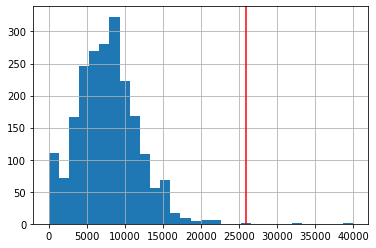

In [31]:
X_train_orig['Local - Personnel'].hist(bins=30)
plt.axvline(x=25885.22, color = 'r')
plt.show()

The original value of this variable for this school is \\$25,885.22.  Looking at the distribution of this variable, this value is already on the upper end of observed values.  We'll create a list of alternative values that go up to \\$40,000 for this variable, with the understanding that it may not be likely that this school will be able to spend this much money from Local sources on Personnel.

In [32]:
# create list of alternative values for 'Local - Personnel'
loc = np.arange(26000, 41000, 1000)

In [33]:
#establish observation as a dataframe
loc_df = pd.DataFrame(X_train_orig.iloc[index]).transpose().reset_index(drop = True)
loc_new_row = pd.DataFrame(X_train_orig.iloc[index]).transpose().reset_index(drop = True)

In [34]:
# iterate through list of alternatives, update variable, and append this new row
for val in loc:
    loc_new_row['Local - Personnel'] = val
    loc_df = loc_df.append(loc_new_row, ignore_index=True)

In [35]:
loc_df

,Title I (Binary),School Enrollment,Male (School),Percent Regular Attendance (All Student),American Indian/Alaskan Native,Asian,Black/African American,Hispanic,Native Hawaiian or other Pacific Islander,2 or More Races,...,Economically Disadvantaged,Foster Care,Homeless,Military Connected,Local - Non-Personnel,Local - Personnel,State - Non-Personnel,State - Personnel,Federal - Non-Personnel,Federal - Personnel
0,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
1,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,26000.00,190.89,171.86,202.98,1716.7
2,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,27000.00,190.89,171.86,202.98,1716.7
3,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,28000.00,190.89,171.86,202.98,1716.7
4,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,29000.00,190.89,171.86,202.98,1716.7
5,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,30000.00,190.89,171.86,202.98,1716.7
6,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,31000.00,190.89,171.86,202.98,1716.7
7,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,32000.00,190.89,171.86,202.98,1716.7
8,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,33000.00,190.89,171.86,202.98,1716.7
9,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,34000.00,190.89,171.86,202.98,1716.7


In [36]:
#scale the data
loc_df_sc = sc.transform(loc_df)

In [37]:
# make prediction
loc_pred = ELA_model.predict(loc_df_sc)

In [38]:
# generate a table comparing the altered value and the predicted target variable
loc_results = pd.DataFrame(zip(loc_df['Local - Personnel'], list(loc_pred)),
             columns = ['Local - Personnel', '% Proficient in ELA (pred)']
            )


loc_results

,Local - Personnel,% Proficient in ELA (pred)
0,25885.22,5.19722
1,26000.00,5.19722
2,27000.00,5.19722
3,28000.00,5.19722
4,29000.00,5.19722
5,30000.00,5.19722
6,31000.00,5.19722
7,32000.00,5.19722
8,33000.00,5.19722
9,34000.00,5.19722


As evident, these increases in 'Local - Personnel' to not cause our model's predictions to improve at all.  

<a id='section4'></a>
## 4. Future work

There is certainly more work that can be explored to potentially improve the performance and interpretability of this model.

- During our exploratory data analysis, a few of our variables had some extreme outliers.  In this project, we checked the validity of those values from a separate source and decided to keep them.  It's possible that removing these outliers may help our models to better model the trend.
- After looking at the SHAP summary analysis, we can use the feature importance bar chart to select the most impactful features and only use them to train a new model, and compare the results of this new model with the previous XGboost models.
- When analyzing counterfactuals, it would be interesting to use create a loss function defined by the predefined threshold (10% in this case) subtracted by the model's output.  We can then use Bayesian optimization to try to minimize this loss function by trying combinations of alternative values of our selected features.
- It may also be interesting to consider looking at two datasets on PA school data from different school years, such as the 2016-2017 school year and then the 2018-2019 school year.  Perhaps a dataset can be constructed with features representing the <b>change</b> in feature values of the two datasets and the target variable representing the <b>change</b> in percent proficiency in ELA and/or math.  It would be interesting to create a model that will demonstrate which changes result in positive changes in school performance, as well as negative changes in school performance.